In [2]:
import torch

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from BatchLayers.StatLayers import Mean, Variance

from CombineLayers.ElementWiseLayers import Add, Multiply, Power, Maximum

from CompoundLayers.SequentialLayer import Sequential
from CompoundLayers.SplitLayer import Split

from MutableLayers.MutableSplitLayers import MutableAddSplit, MutableMulSplit, MutableMaxSplit, MutablePowSplit
from MutableLayers.MutableResizeLayers import MutableResizeFive, MutableResizeFifth

from OpLayers.AffineLayers import Linear, AddBias, LinearResize
from OpLayers.ScalarFuncLayers import Log, Exp, Identity, Abs, Sin, Reciprocal
from OpLayers.VectorFuncLayers import Pow, Scale

from SamplePopulation import NSGIISamplePopulation, NSGIIChainSamplePopulation, NSGIICompoundSamplePopulation

from SampleLayers.SampleSequentialLayer import SampleSequential
from SampleLayers.SampleSplitLayer import SampleSplit, SampleSplitAdd, SampleSplitMaximum, SampleSplitMultiply, SampleSplitPower
from SampleLayers.SampleResizeLayer import SampleResize, SampleResizeFive, SampleResizeFifth, SampleResizeHalf, SampleResizeTwo
from SampleLayers.SampleCompoundLayer import SampleCompound
from SampleLayers.SampleChainLayer import SampleChain

torch.set_printoptions(threshold=10000)

In [21]:
# op_layers = [ Linear, AddBias, Sin, Pow, Identity ]
op_layers = [ Linear, AddBias, Sin, Pow, Exp ]
split_layers = [ MutableAddSplit, MutableMulSplit, MutableMaxSplit, MutablePowSplit ]
batch_layers = [ Mean, Variance ]
resize_layers = [ MutableResizeFive, MutableResizeFifth]

# compound_layers = [ SampleSequential, SampleSplitAdd, SampleSplitMaximum, SampleSplitMultiply, SampleResizeFive, SampleResizeTwo ]
compound_layers = [ SampleSequential, SampleSplitAdd, SampleSplitMaximum, SampleSplitMultiply, SampleResizeFive, SampleResizeTwo ]
# compound_layers = [ SampleSequential, SampleSplitAdd, SampleSplitMaximum, SampleResizeFive, SampleResizeTwo ]

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

A = torch.randn(size=(1, 5), device=device)
B = torch.randn(size=(5, 1), device=device)

f = lambda x : torch.sin(x @ A) @ B
# f = lambda x : torch.nn.functional.sigmoid(x)

x_train = torch.tensor(np.linspace(start=-20, stop=20, num=500).reshape((500, 1)), dtype=torch.float32, device=device)
y_train = f(x_train)

x_test = torch.tensor(np.random.uniform(-20, 20, size=(500, 1)), dtype=torch.float32, device=device)
y_test = f(x_test)

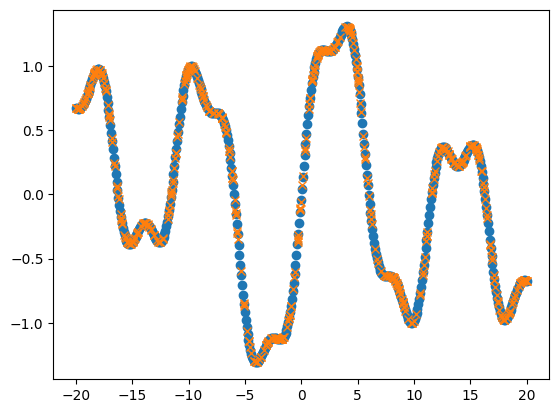

In [14]:
plt.plot(x_train.clone().detach().cpu().numpy(), y_train.clone().detach().cpu().numpy(), 'o')
plt.plot(x_test.clone().detach().cpu().numpy(), y_test.clone().detach().cpu().numpy(), 'x')
plt.show()

In [6]:
n = 10000

max_depth = 4
chain_length = 1

num_layers = len(op_layers)
num_compound_layers = len(compound_layers)

dim = 1

fair_epochs = 50
batch_size = 32
runs = 50

best_epochs = 10

k = 3

In [22]:
sample_chain = SampleChain(dim, dim * 5, dim, max_depth, op_layers, compound_layers, chain_length, shared=False, lr=0.01).to(device)
sample_chain_pop = NSGIIChainSamplePopulation(sample_chain, n)

In [334]:
# sample_chain.freeze_chain()
sample_chain.add_chain_links(1)

sample_chain.to(device)

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [23]:
sample_chain_pop.train_fair_dataset(x_train, y_train, fair_epochs, batch_size)

Training: 100%|██████████| 50/50 [00:30<00:00,  1.62it/s]


Evaluating Pool: 100%|██████████| 10000/10000 [00:06<00:00, 1551.54it/s]


Supernet SampleChain(
  dim=1
  (chain): ModuleList(
    (0): SampleCompound(
      dim=1
      (grid): ModuleList(
        (0): ModuleList(
          (0): Linear(
            in_dim=5, out_dim=5, A=[[-0.06519661 -0.7008837   0.2839979   0.46654746  1.0966388 ]
             [-1.582864    0.05185594 -0.756722   -0.79071015  0.5751336 ]
             [-1.3062661  -0.44516897 -0.5474452   0.1136682   0.40305594]
             [ 1.2618673   0.28445816  1.7154553  -0.7710776   0.5095864 ]
             [-0.11474081  0.24726969 -0.5049807  -0.28013518  0.71995026]]
          )
          (1): AddBias(dim=5, b=[-0.8239769  -0.6693188  -0.99279284 -0.7111306   0.39472443])
          (2): Sin(dim=5)
          (3): Pow(dim=5, exp=[-0.40660182  0.23170364  0.7919265   0.35906774  0.27504542])
          (4): Exp(dim=5)
        )
        (1): ModuleList(
          (0): Linear(
            in_dim=5, out_dim=5, A=[[ 1.1691865   1.4845797   0.9887333   1.1844962   1.5018877 ]
             [ 0.09565955 -1.

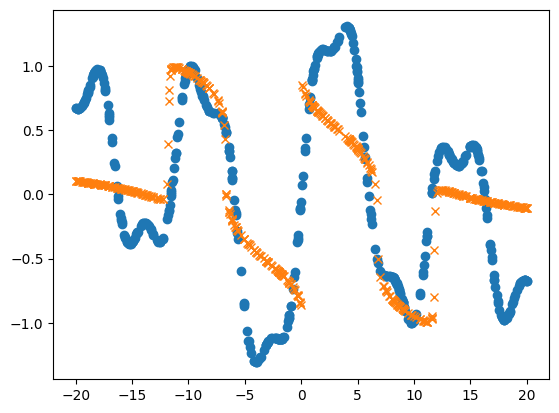

In [24]:
sample_chain_pop.initialize_randomly()
sample_chain_pop.evaluate_pool_dataset(x_test, y_test)

print(f"Supernet {sample_chain_pop.supernet.cpu()}")
sample_chain_pop.supernet.to(device)

# print(f"Pool {sample_chain_pop.pool}")
# print(f"Stats {sample_chain_pop.stats}")

min_idx = torch.argmin(torch.nan_to_num(sample_chain_pop.stats[:, 0], nan=torch.inf))
print(f"Min {sample_chain_pop.stats[min_idx]}")
print(f"Min Path {sample_chain_pop.pool[min_idx]}")

min_path = sample_chain_pop.pool[min_idx]

plt.plot(x_test.clone().detach().cpu().numpy(), y_test.clone().detach().cpu().numpy(), 'o')
plt.plot(x_test.clone().detach().cpu().numpy(), sample_chain_pop.supernet(min_path, x_test).clone().detach().cpu().numpy(), 'x')
plt.show()

# sample_chain.train_dataset(x_train, y_train, fair_epochs, batch_size, [min_path])

# plt.plot(x_test.clone().detach().cpu().numpy(), y_test.clone().detach().cpu().numpy(), 'o')
# plt.plot(x_test.clone().detach().cpu().numpy(), sample_chain_pop.supernet(min_path, x_test).clone().detach().cpu().numpy(), 'x')
# plt.show()

Training: 100%|██████████| 100/100 [00:05<00:00, 19.83it/s]


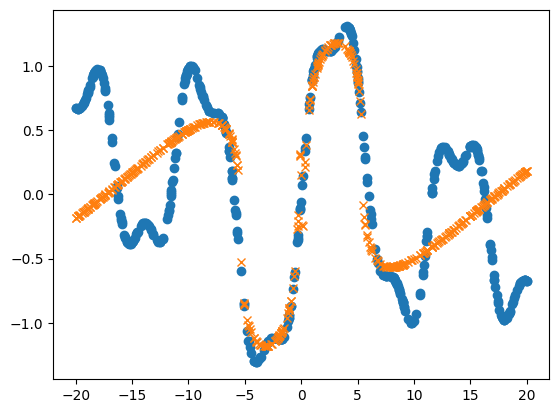

In [29]:
sample_chain.train_dataset(x_train, y_train, 100, batch_size, [min_path])

plt.plot(x_test.clone().detach().cpu().numpy(), y_test.clone().detach().cpu().numpy(), 'o')
plt.plot(x_test.clone().detach().cpu().numpy(), sample_chain_pop.supernet(min_path, x_test).clone().detach().cpu().numpy(), 'x')
plt.show()

In [34]:
output = new_sample_chain_pop.supernet(min_path, x_train).detach()

In [35]:
new_chain = SampleChain(dim, dim * 5, dim, max_depth, op_layers, compound_layers, chain_length, shared=False, lr=0.01).to(device)
new_sample_chain_pop = NSGIIChainSamplePopulation(sample_chain, n)
new_sample_chain_pop.train_fair_dataset(output, y_train, fair_epochs, batch_size)

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Training: 100%|██████████| 500/500 [00:40<00:00, 12.40it/s]


Evaluating Pool: 100%|██████████| 50000/50000 [00:44<00:00, 1130.96it/s]


Supernet SampleChain(
  dim=1
  (chain): ModuleList(
    (0): SampleCompound(
      dim=1
      (grid): ModuleList(
        (0): ModuleList(
          (0): Linear(
            in_dim=5, out_dim=5, A=[[ 0.32910392 -0.71969426  0.3949573   0.06747888 -0.08396411]
             [-0.41240308  0.7024306  -0.12452652  0.70001596 -0.24994469]
             [ 0.23176944 -0.39952588  0.0989216  -0.05623354  0.36009228]
             [-0.20372564 -0.06405656  0.24202104  0.05787456 -0.2528948 ]
             [ 0.21060093  0.42168963 -0.37424734  0.11860889  0.20639771]]
          )
          (1): AddBias(dim=5, b=[-0.9716102  -0.6155114  -0.1919198  -0.28370813  0.07626195])
          (2): Sin(dim=5)
          (3): Pow(dim=5, exp=[0.51314235 1.9434644  0.98991466 0.88496035 0.5121668 ])
          (4): Exp(dim=5)
          (5): Identity(dim=5)
        )
        (1): ModuleList(
          (0): Linear(
            in_dim=5, out_dim=5, A=[[ 0.284616   -0.5532821   0.05737649 -0.27865997  0.31784028]
   

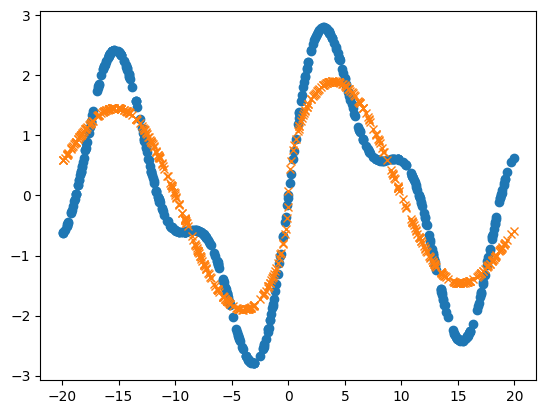

In [36]:
new_sample_chain_pop.initialize_randomly()
new_sample_chain_pop.evaluate_pool_dataset(x_test, y_test)

print(f"Supernet {new_sample_chain_pop.supernet.cpu()}")
new_sample_chain_pop.supernet.to(device)

# print(f"Pool {sample_chain_pop.pool}")
# print(f"Stats {sample_chain_pop.stats}")

min_idx = torch.argmin(torch.nan_to_num(new_sample_chain_pop.stats[:, 0], nan=torch.inf))
print(f"Min {new_sample_chain_pop.stats[min_idx]}")
print(f"Min Path {new_sample_chain_pop.pool[min_idx]}")

min_path = new_sample_chain_pop.pool[min_idx]

plt.plot(x_test.clone().detach().cpu().numpy(), y_test.clone().detach().cpu().numpy(), 'o')
plt.plot(x_test.clone().detach().cpu().numpy(), new_sample_chain_pop.supernet(min_path, x_test).clone().detach().cpu().numpy(), 'x')
plt.show()

In [8]:
sample_chain.train_dataset(x_train, y_train, 10, batch_size, min_path)

Training: 100%|██████████| 10/10 [00:00<00:00, 62.26it/s]


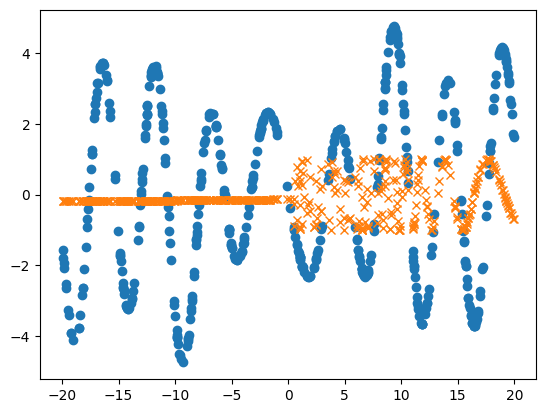

In [9]:
plt.plot(x_test.clone().detach().cpu().numpy(), y_test.clone().detach().cpu().numpy(), 'o')
plt.plot(x_test.clone().detach().cpu().numpy(), sample_chain_pop.supernet(min_path, x_test).clone().detach().cpu().numpy(), 'x')
plt.show()

In [14]:
sample_chain.freeze_chain()
sample_chain.add_chain_links(1)

sample_chain.to(device)
sample_chain_pop.train_fair_dataset(x_train, y_train, fair_epochs, batch_size)

Training: 100%|██████████| 500/500 [00:53<00:00,  9.38it/s]


Evaluating Pool: 100%|██████████| 50000/50000 [01:20<00:00, 623.82it/s]


Supernet SampleChain(
  dim=1
  (chain): ModuleList(
    (0): SampleCompound(
      dim=1
      (grid): ModuleList(
        (0): ModuleList(
          (0): Linear(
            in_dim=5, out_dim=5, A=[[ 0.05504643  0.14057884 -1.041191   -0.38847062  0.08636472]
             [ 0.02125894  0.5653889  -1.305261    0.1452405  -0.42164397]
             [-0.8304652  -0.20452641 -0.07044259  1.4712278   0.6702959 ]
             [ 0.74513936  0.9340036   0.77161956 -0.48675317  0.53735393]
             [-1.2558124   0.23028086  0.03008901  0.5817415  -0.38807213]]
          )
          (1): AddBias(dim=5, b=[-1.814439   -0.49757868  0.5498256  -0.23567505  0.6394414 ])
          (2): Sin(dim=5)
          (3): Pow(dim=5, exp=[-0.1726366   0.23765598 -0.25978157  0.546089    0.29922226])
          (4): Exp(dim=5)
          (5): Identity(dim=5)
        )
        (1): ModuleList(
          (0): Linear(
            in_dim=5, out_dim=5, A=[[ 0.01821688  0.01002203  1.0141909  -1.5772958  -0.740757  

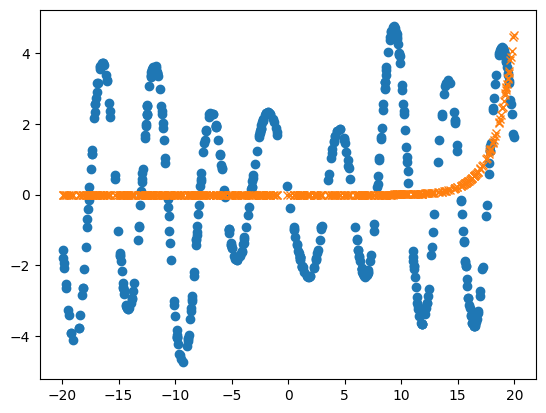

In [15]:
sample_chain_pop.initialize_randomly()
sample_chain_pop.evaluate_pool_dataset(x_test, y_test)

print(f"Supernet {sample_chain_pop.supernet.cpu()}")
sample_chain_pop.supernet.to(device)

# print(f"Pool {sample_chain_pop.pool}")
# print(f"Stats {sample_chain_pop.stats}")

min_idx = torch.argmin(torch.nan_to_num(sample_chain_pop.stats[:, 0], nan=torch.inf))
print(f"Min {sample_chain_pop.stats[min_idx]}")
print(f"Min Path {sample_chain_pop.pool[min_idx]}")

min_path = sample_chain_pop.pool[min_idx]

plt.plot(x_test.clone().detach().cpu().numpy(), y_test.clone().detach().cpu().numpy(), 'o')
plt.plot(x_test.clone().detach().cpu().numpy(), sample_chain_pop.supernet(min_path, x_test).clone().detach().cpu().numpy(), 'x')
plt.show()

Computing fronts: 100%|██████████| 450/450 [00:01<00:00, 327.17it/s]

Supernet SampleResizeFive(
  dim=1
  (first): LinearResize(
    in_dim=1, out_dim=5, A=[[ 1.0550547e+00 -1.2826350e+00  1.5522097e-01  2.0794460e-04
       1.7478169e+00]]
  )
  (grid): ModuleList(
    (0): ModuleList(
      (0): Linear(
        in_dim=5, out_dim=5, A=[[ 1.4158713   0.5466741   0.05756081 -1.4089794  -0.05362822]
         [ 0.9923314   0.23819555  0.5797438   1.564257    1.4905394 ]
         [-0.68458295  1.9421961   0.43356898  1.006918   -1.0634228 ]
         [-1.6686314  -1.0120437  -1.0410881  -0.8669356   0.9732893 ]
         [ 1.6540612  -2.350858   -0.30990574  1.1213166   0.05466415]]
      )
      (1): AddBias(dim=5, b=[-0.35578066 -1.260779    1.9096398  -0.02382079 -0.05809028])
      (2): Sin(dim=5)
      (3): Pow(dim=5, exp=[ 1.7842104  -0.48118258 -0.00771303 -0.9120221  -0.7896034 ])
      (4): Exp(dim=5)
      (5): Identity(dim=5)
    )
    (1): ModuleList(
      (0): Linear(
        in_dim=5, out_dim=5, A=[[ 0.15888295 -0.560653    0.09022646  0.274033

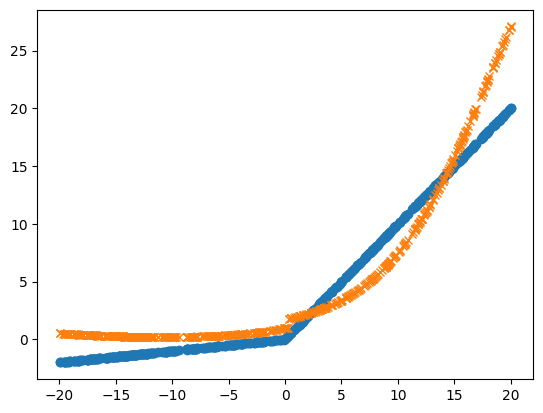

Computing fronts: 100%|██████████| 450/450 [00:01<00:00, 374.32it/s]


Supernet SampleSplitAdd(
  dim=1
  (combine): Add(dim=1)
  (left): ModuleList(
    (0): ModuleList(
      (0): Linear(in_dim=1, out_dim=1, A=[[0.0905647]])
      (1): AddBias(dim=1, b=[-1.9750241])
      (2): Sin(dim=1)
      (3): Pow(dim=1, exp=[0.18086566])
      (4): Exp(dim=1)
      (5): Identity(dim=1)
    )
    (1): ModuleList(
      (0): Linear(in_dim=1, out_dim=1, A=[[0.07299856]])
      (1): AddBias(dim=1, b=[-0.30883396])
      (2): Sin(dim=1)
      (3): Pow(dim=1, exp=[0.28569874])
      (4): Exp(dim=1)
      (5): Identity(dim=1)
    )
    (2): ModuleList(
      (0): Linear(in_dim=1, out_dim=1, A=[[0.04723741]])
      (1): AddBias(dim=1, b=[0.01094637])
      (2): Sin(dim=1)
      (3): Pow(dim=1, exp=[0.21093312])
      (4): Exp(dim=1)
      (5): Identity(dim=1)
    )
  )
  (right): ModuleList(
    (0): ModuleList(
      (0): Linear(in_dim=1, out_dim=1, A=[[0.19154654]])
      (1): AddBias(dim=1, b=[-1.7776457])
      (2): Sin(dim=1)
      (3): Pow(dim=1, exp=[0.07337429])
 

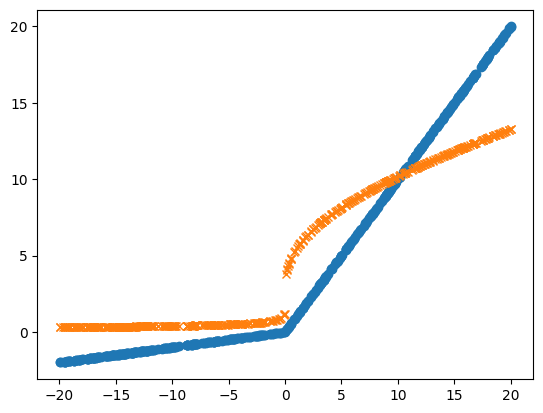

Computing fronts: 100%|██████████| 450/450 [00:01<00:00, 288.83it/s]

Supernet SampleSplitMaximum(
  dim=1
  (combine): Maximum(dim=1)
  (left): ModuleList(
    (0): ModuleList(
      (0): Linear(in_dim=1, out_dim=1, A=[[0.32574788]])
      (1): AddBias(dim=1, b=[-3.607631])
      (2): Sin(dim=1)
      (3): Pow(dim=1, exp=[0.36611596])
      (4): Exp(dim=1)
      (5): Identity(dim=1)
    )
    (1): ModuleList(
      (0): Linear(in_dim=1, out_dim=1, A=[[0.14990076]])
      (1): AddBias(dim=1, b=[-1.9718353])
      (2): Sin(dim=1)
      (3): Pow(dim=1, exp=[0.4336936])
      (4): Exp(dim=1)
      (5): Identity(dim=1)
    )
    (2): ModuleList(
      (0): Linear(in_dim=1, out_dim=1, A=[[0.05874797]])
      (1): AddBias(dim=1, b=[-2.2666562])
      (2): Sin(dim=1)
      (3): Pow(dim=1, exp=[0.5058397])
      (4): Exp(dim=1)
      (5): Identity(dim=1)
    )
  )
  (right): ModuleList(
    (0): ModuleList(
      (0): Linear(in_dim=1, out_dim=1, A=[[0.45335633]])
      (1): AddBias(dim=1, b=[-3.7369342])
      (2): Sin(dim=1)
      (3): Pow(dim=1, exp=[0.1890430

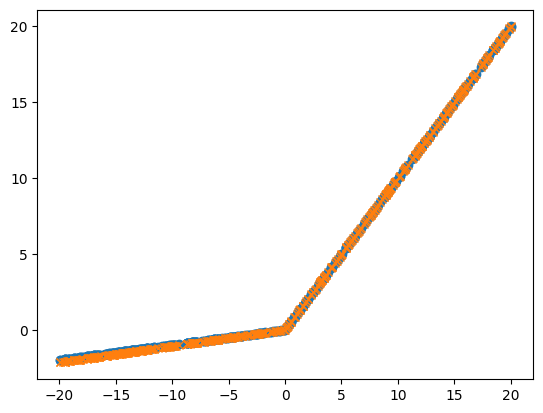

Computing fronts: 100%|██████████| 450/450 [00:01<00:00, 340.55it/s]


Supernet SampleSplitMultiply(
  dim=1
  (combine): Multiply(dim=1)
  (left): ModuleList(
    (0): ModuleList(
      (0): Linear(in_dim=1, out_dim=1, A=[[0.02950027]])
      (1): AddBias(dim=1, b=[-1.6891501])
      (2): Sin(dim=1)
      (3): Pow(dim=1, exp=[-0.3730411])
      (4): Exp(dim=1)
      (5): Identity(dim=1)
    )
    (1): ModuleList(
      (0): Linear(in_dim=1, out_dim=1, A=[[0.00157309]])
      (1): AddBias(dim=1, b=[-0.48847014])
      (2): Sin(dim=1)
      (3): Pow(dim=1, exp=[0.154657])
      (4): Exp(dim=1)
      (5): Identity(dim=1)
    )
    (2): ModuleList(
      (0): Linear(in_dim=1, out_dim=1, A=[[-0.00617266]])
      (1): AddBias(dim=1, b=[-0.04245858])
      (2): Sin(dim=1)
      (3): Pow(dim=1, exp=[0.22656111])
      (4): Exp(dim=1)
      (5): Identity(dim=1)
    )
  )
  (right): ModuleList(
    (0): ModuleList(
      (0): Linear(in_dim=1, out_dim=1, A=[[0.09387072]])
      (1): AddBias(dim=1, b=[0.05848172])
      (2): Sin(dim=1)
      (3): Pow(dim=1, exp=[-0.

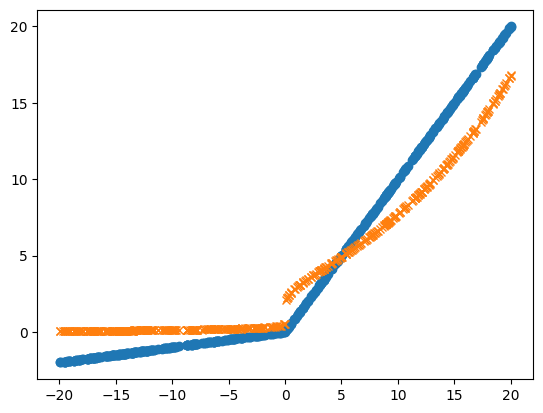

Computing fronts: 100%|██████████| 450/450 [00:01<00:00, 332.84it/s]


Supernet SampleSplitPower(
  dim=1
  (combine): Power(dim=1)
  (left): ModuleList(
    (0): ModuleList(
      (0): Linear(in_dim=1, out_dim=1, A=[[0.17224911]])
      (1): AddBias(dim=1, b=[0.99215573])
      (2): Sin(dim=1)
      (3): Pow(dim=1, exp=[0.00911453])
      (4): Exp(dim=1)
      (5): Identity(dim=1)
    )
    (1): ModuleList(
      (0): Linear(in_dim=1, out_dim=1, A=[[0.18582009]])
      (1): AddBias(dim=1, b=[-0.5854355])
      (2): Sin(dim=1)
      (3): Pow(dim=1, exp=[0.31558216])
      (4): Exp(dim=1)
      (5): Identity(dim=1)
    )
    (2): ModuleList(
      (0): Linear(in_dim=1, out_dim=1, A=[[0.73725337]])
      (1): AddBias(dim=1, b=[0.3886053])
      (2): Sin(dim=1)
      (3): Pow(dim=1, exp=[0.10503445])
      (4): Exp(dim=1)
      (5): Identity(dim=1)
    )
  )
  (right): ModuleList(
    (0): ModuleList(
      (0): Linear(in_dim=1, out_dim=1, A=[[-0.1451547]])
      (1): AddBias(dim=1, b=[0.7498062])
      (2): Sin(dim=1)
      (3): Pow(dim=1, exp=[-1.3028474])

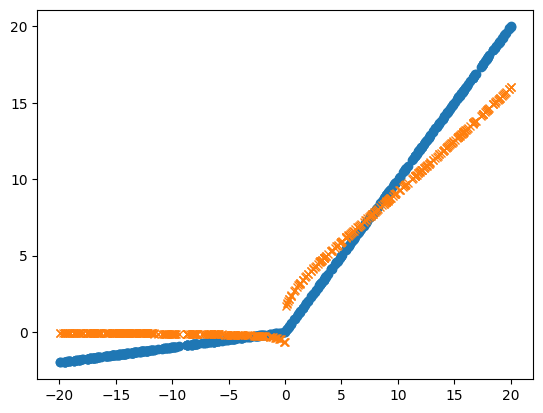

Computing fronts: 100%|██████████| 450/450 [00:01<00:00, 323.14it/s]


Supernet SampleSequential(
  dim=1
  (grid): ModuleList(
    (0): ModuleList(
      (0): Linear(in_dim=1, out_dim=1, A=[[0.5703065]])
      (1): AddBias(dim=1, b=[-1.9746394])
      (2): Sin(dim=1)
      (3): Pow(dim=1, exp=[0.21648212])
      (4): Exp(dim=1)
      (5): Identity(dim=1)
    )
    (1): ModuleList(
      (0): Linear(in_dim=1, out_dim=1, A=[[0.43637413]])
      (1): AddBias(dim=1, b=[-1.1958089])
      (2): Sin(dim=1)
      (3): Pow(dim=1, exp=[0.31796926])
      (4): Exp(dim=1)
      (5): Identity(dim=1)
    )
    (2): ModuleList(
      (0): Linear(in_dim=1, out_dim=1, A=[[0.09650247]])
      (1): AddBias(dim=1, b=[-1.1657952])
      (2): Sin(dim=1)
      (3): Pow(dim=1, exp=[0.48776895])
      (4): Exp(dim=1)
      (5): Identity(dim=1)
    )
    (3): ModuleList(
      (0): Linear(in_dim=1, out_dim=1, A=[[0.08223934]])
      (1): AddBias(dim=1, b=[-0.935465])
      (2): Sin(dim=1)
      (3): Pow(dim=1, exp=[0.49030894])
      (4): Exp(dim=1)
      (5): Identity(dim=1)
   

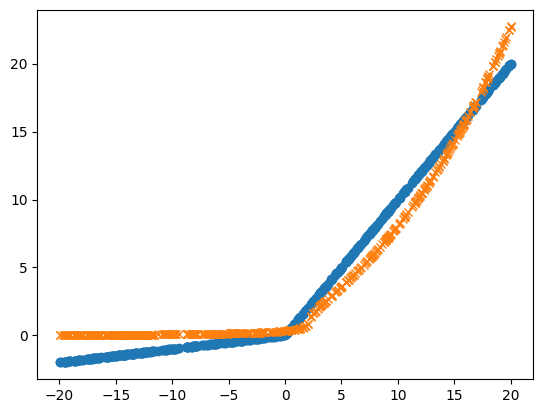

[tensor(4.3991), tensor(6.9388), tensor(0.0048), tensor(3.9106), tensor(2.6043), tensor(1.8005)]
[tensor(50.5478), tensor(28.7237), tensor(12.2869), tensor(45.3955), tensor(44.1330), tensor(41.6342)]


In [8]:
segments = torch.nn.ModuleList([ SampleResizeFive(dim, max_depth, op_layers, lr=0.01), SampleSplitAdd(dim, max_depth, op_layers, lr=0.01), SampleSplitMaximum(dim, max_depth, op_layers, lr=0.01), SampleSplitMultiply(dim, max_depth, op_layers, lr=0.01), SampleSplitPower(dim, max_depth, op_layers, lr=0.01), SampleSequential(dim, max_depth, op_layers, lr=0.01) ])
segments.to(device)

min_path = []
min_acc = []
avg_acc = []

for segment in segments:
    population = NSGIISamplePopulation(segment, n, torch.randint(0, num_layers, (n, max_depth)))
    population.train_fair_dataset(x_train, y_train, epochs=fair_epochs, batch_size=batch_size)
    population.evaluate_pool_dataset(x_test, y_test)

    for _ in range(3):
        population.gen_children(k=k)
        population.evaluate_children_dataset(x_test, y_test)

        population.step(percentile=0.75)

    min_acc.append(torch.min(population.stats[:, 0]))
    avg_acc.append(torch.mean(population.stats[:, 0]))

    print(f"Supernet {population.supernet.cpu()}")
    population.supernet.to(device)

    print(f"Pool {population.pool}")
    print(f"Stats {population.stats}")

    plt.plot(x_test.clone().detach().cpu().numpy(), y_test.clone().detach().cpu().numpy(), 'o')
    plt.plot(x_test.clone().detach().cpu().numpy(), population.supernet(population.pool[0], x_test).clone().detach().cpu().numpy(), 'x')
    plt.show()

print(min_acc)
print(avg_acc)

In [31]:
data = pd.read_csv("data/StudentPerformance/data.csv")

predictors = data.drop(columns=["StudentID", "GPA", "GradeClass"], axis=1)
targets = data["GPA"]

train_ratio = 0.8
split = torch.randperm(len(predictors))

train_split = split[:int(train_ratio * len(data))]
test_split = split[int(train_ratio * len(data)):]

device = torch.device("cuda")

x_train = torch.tensor(predictors.values[train_split], dtype=torch.float32).to(device)
y_train = torch.tensor(targets.values[train_split], dtype=torch.float32).view(-1, 1).to(device)

x_test = torch.tensor(predictors.values[test_split], dtype=torch.float32).to(device)
y_test = torch.tensor(targets.values[test_split], dtype=torch.float32).view(-1, 1).to(device)

In [3]:
n = 50000
k = 3

max_depth = 6
dim = len(predictors.columns)
chain_length = 1

batch_size = 32
fair_epochs = 500

indiv_epochs = 200

In [4]:
op_layers = [ Linear, AddBias, Sin, Pow, Exp, Identity ]
split_layers = [ MutableAddSplit, MutableMulSplit, MutableMaxSplit, MutablePowSplit ]
batch_layers = [ Mean, Variance ]
resize_layers = [ MutableResizeFive, MutableResizeFifth]

compound_layers = [ SampleSequential, SampleSplitAdd, SampleSplitMaximum, SampleSplitMultiply, SampleSplitPower, SampleResizeTwo, SampleResizeHalf]

In [5]:
sample_chain = SampleChain(dim, dim * 2, 1, max_depth, op_layers, compound_layers, chain_length, lr=0.01).to(device)

sample_chain_pop = NSGIIChainSamplePopulation(sample_chain, n)
sample_chain_pop.train_fair_dataset(x_train, y_train, fair_epochs, batch_size)

Training: 100%|██████████| 500/500 [05:23<00:00,  1.55it/s]


In [6]:
sample_chain_pop.initialize_randomly()
sample_chain_pop.evaluate_pool_dataset(x_test, y_test)

print(f"Supernet {sample_chain_pop.supernet.cpu()}")
sample_chain_pop.supernet.to(device)

# print(f"Pool {sample_chain_pop.pool}")
# print(f"Stats {sample_chain_pop.stats}")

min_idx = torch.argmin(torch.nan_to_num(sample_chain_pop.stats[:, 0], nan=torch.inf))
print(f"Min {sample_chain_pop.stats[min_idx]}")
print(f"Min Path {sample_chain_pop.pool[min_idx]}")

min_path = sample_chain_pop.pool[min_idx]

Evaluating Pool: 100%|██████████| 50000/50000 [00:39<00:00, 1264.82it/s]


Supernet SampleChain(
  dim=12
  (chain): ModuleList(
    (0): SampleCompound(
      dim=12
      (grid): ModuleList(
        (0): ModuleList(
          (0): Linear(
            in_dim=60, out_dim=60, A=[[-1.197233    0.08726596 -0.25385034 ...  0.28353852  0.26276347
              -0.56446636]
             [ 0.7983068  -0.03620309  0.1166766  ... -0.65680397  0.09531051
              -0.17734618]
             [-0.85111064 -0.5268365   0.23260999 ... -0.5837964  -0.10618047
              -1.1154988 ]
             ...
             [ 0.07188561 -1.0450666  -0.6282269  ... -1.4365041  -0.13568082
               0.4458892 ]
             [-0.3665425   0.5165552  -0.89101976 ...  0.09465728  0.4359885
               0.01800572]
             [ 2.3639245  -0.8937063  -0.6223846  ... -0.56672055  0.17896323
              -0.8465649 ]]
          )
          (1): AddBias(
            dim=60, b=[ 1.1169138   1.0113224  -0.5282389   0.55593747  0.932529    1.4589533
              0.8267844  -0.9693

In [16]:
sample_chain.train_dataset(x_train, y_train, indiv_epochs, batch_size, min_path)

Training: 100%|██████████| 500/500 [01:35<00:00,  5.22it/s]


In [7]:
print(sample_chain.evaluate_dataset(x_train, y_train, min_path))
print(sample_chain.evaluate_dataset(x_test, y_test, min_path))

0.524967610836029
0.5101088285446167


In [32]:
train_data = pd.read_csv("data/ConcreteStrength/train.csv")
val_data = pd.read_csv("data/ConcreteStrength/test.csv")

train_predictors = train_data.drop(["id", "Strength"], axis=1)
val_predictors = val_data.drop(["id"], axis=1)

train_targets = train_data["Strength"]

train_ratio = 1.0
split = torch.randperm(len(train_predictors))

train_split = split[:int(train_ratio * len(train_predictors))]
test_split = split[int(train_ratio * len(train_predictors)):]

device = torch.device("cuda")

x_train = torch.tensor(train_predictors.values[train_split], dtype=torch.float32).to(device)
y_train = torch.tensor(train_targets.values[train_split], dtype=torch.float32).view(-1, 1).to(device)

x_test = torch.tensor(train_predictors.values[test_split], dtype=torch.float32).to(device)
y_test = torch.tensor(train_targets.values[test_split], dtype=torch.float32).view(-1, 1).to(device)

In [93]:
x_val = torch.tensor(val_predictors.values, dtype=torch.float32).to(device)

In [33]:
n = 50000
k = 3

max_depth = 6
dim = len(train_predictors.columns)
chain_length = 1

batch_size = 32
fair_epochs = 200

indiv_epochs = 200

In [34]:
op_layers = [ Linear, AddBias, Sin, Pow, Exp ]
split_layers = [ MutableAddSplit, MutableMulSplit, MutableMaxSplit, MutablePowSplit ]
batch_layers = [ Mean, Variance ]
resize_layers = [ MutableResizeFive, MutableResizeFifth ]

compound_layers = [ SampleSequential, SampleSplitAdd, SampleSplitMaximum, SampleSplitMultiply, SampleResizeFive, SampleResizeFifth, SampleResizeHalf, SampleResizeTwo]

In [35]:
sample_chain = SampleChain(dim, dim * 5, 1, max_depth, op_layers, compound_layers, chain_length, lr=0.01).to(device)
sample_chain_pop = NSGIIChainSamplePopulation(sample_chain, n)

In [39]:
sample_chain.add_chain_links(1)
sample_chain.to(device)

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [40]:
sample_chain_pop.train_fair_dataset(x_train, y_train, fair_epochs, batch_size)

Training:  28%|██▊       | 57/200 [20:05<50:42, 21.28s/it]  

In [38]:
sample_chain_pop.initialize_randomly()
sample_chain_pop.evaluate_pool_dataset(x_train, y_train)

print(f"Pool {sample_chain_pop.pool}")

print(f"Supernet {sample_chain_pop.supernet.cpu()}")
sample_chain_pop.supernet.to(device)

# print(f"Pool {sample_chain_pop.pool}")
# print(f"Stats {sample_chain_pop.stats}")

min_idx = torch.argmin(torch.nan_to_num(sample_chain_pop.stats[:, 0], nan=torch.inf))
min_path = sample_chain_pop.pool[min_idx]

print(f"Min {sample_chain_pop.stats[min_idx]}")
print(f"Min Path Eval {sample_chain.evaluate_dataset(x_train, y_train, min_path)}")
print(f"Min Path {min_path}")

Evaluating Pool: 100%|██████████| 50000/50000 [00:42<00:00, 1166.67it/s]

Pool tensor([[5, 2, 1,  ..., 3, 3, 4],
        [1, 0, 1,  ..., 2, 4, 0],
        [5, 0, 1,  ..., 1, 4, 1],
        ...,
        [4, 0, 0,  ..., 1, 4, 3],
        [6, 2, 4,  ..., 0, 3, 1],
        [4, 1, 3,  ..., 0, 3, 4]])
Supernet SampleChain(
  dim=8
  (chain): ModuleList(
    (0): SampleCompound(
      dim=8
      (grid): ModuleList(
        (0): ModuleList(
          (0): Linear(
            in_dim=40, out_dim=40, A=[[ 2.0403306  -0.25965923  0.34927577 ...  0.47837096  0.9649126
               0.91790044]
             [ 0.00967257  0.7156051  -0.4192677  ... -1.0927975  -1.1264617
              -0.08937157]
             [ 0.781204   -0.24075538 -0.10784678 ... -0.3893694   1.4011484
               0.6606791 ]
             ...
             [ 1.1408725  -0.16705045 -0.2062496  ... -0.38054863  1.0368142
              -0.09897407]
             [ 2.0311227   0.7773823   0.21256925 ... -0.02622936 -0.06622948
               1.7737821 ]
             [ 2.1090696  -0.33951     1.3258809  

In [112]:
print(x_train[0, :].shape)

torch.Size([8])


In [113]:
sample_chain.forward(min_path, x_train[0, :].reshape(1, -1))

tensor([[nan]], device='cuda:0', grad_fn=<MmBackward0>)

In [230]:
for group in sample_chain.optimizer.param_groups:
    group['lr'] = 0.001

In [333]:
sample_chain.train_dataset(x_train, y_train, 1, batch_size, min_path)

Training: 100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


In [334]:
print(sample_chain.evaluate_dataset(x_train, y_train, min_path))
print(sample_chain.evaluate_dataset(x_test, y_test, min_path))

204.54800415039062
180.83706665039062


In [110]:
val_preds = sample_chain.forward(min_path, x_val)

output_df = pd.DataFrame(data={"id": val_data["id"], "Strength": val_preds.cpu().detach().numpy().flatten()})
val_preds.to(device)

output_df.to_csv("data/ConcreteStrength/submission.csv", index=False)